In [2]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import load_model


import pickle
from matplotlib import pyplot as plt

In [3]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):

        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)

        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):

        # replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train(self, num_episodes=2000, can_stop=True):
        for episode in range(num_episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, self.num_observation_space])
            for step in range(num_steps):
                env.render()
                received_action = self.get_action(state)
                # print("received_action:", received_action)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                # Store the experience in replay memory
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                # add up rewards
                reward_for_episode += reward
                state = next_state
                self.update_counter()
                self.learn_and_update_weights_by_reply()

                if done:
                    break
            self.rewards_list.append(reward_for_episode)

            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Check for breaking condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 200 and can_stop:
                print("DQN Training Complete...")
                break
            print(episode, "\t: Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",last_rewards_mean, "\t epsilon: ", self.epsilon )

    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

In [4]:
def test_already_trained_model(trained_model):
    rewards_list = []
    num_test_episode = 100
    env = gym.make("LunarLander-v2")
    print("Starting Testing of the trained model...")

    step_count = 1000

    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        print(test_episode, "\t: Episode || Reward: ", reward_for_episode)

    return rewards_list


In [5]:
def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df['rolling_mean'] = df[df.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    # plt.ylim((-400, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(False)
    fig.savefig(chart_name)


def plot_df2(df, chart_name, title, x_axis_label, y_axis_label):
    df['mean'] = df[df.columns[0]].mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((0, 300))
    plt.xlim((0, 100))
    plt.legend().set_visible(False)
    fig = plot.get_figure()
    fig.savefig(chart_name)


def plot_experiments(df, chart_name, title, x_axis_label, y_axis_label, y_limit):
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1, figsize=(15, 8), title=title)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim(y_limit)
    fig = plot.get_figure()
    fig.savefig(chart_name)


In [6]:
def run_experiment_for_gamma():
    print('Running Experiment for gamma...')
    env = gym.make('LunarLander-v2')

    # set seeds
    env.seed(21)
    np.random.seed(21)

    # setting up params
    lr = 0.001
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma_list = [0.99, 0.9, 0.8, 0.7]
    training_episodes = 1000

    rewards_list_for_gammas = []
    for gamma_value in gamma_list:
        # save_dir = "hp_gamma_"+ str(gamma_value) + "_"
        model = DQN(env, lr, gamma_value, epsilon, epsilon_decay)
        print("Training model for Gamma: {}".format(gamma_value))
        model.train(training_episodes, False)
        rewards_list_for_gammas.append(model.rewards_list)

    pickle.dump(rewards_list_for_gammas, open("rewards_list_for_gammas.p", "wb"))
    rewards_list_for_gammas = pickle.load(open("rewards_list_for_gammas.p", "rb"))

    gamma_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes + 1)))
    for i in range(len(gamma_list)):
        col_name = "gamma=" + str(gamma_list[i])
        gamma_rewards_pd[col_name] = rewards_list_for_gammas[i]
    plot_experiments(gamma_rewards_pd, "Figure 4: Rewards per episode for different gamma values",
                     "Figure 4: Rewards per episode for different gamma values", "Episodes", "Reward", (-600, 300))



In [7]:
def run_experiment_for_lr():
    print('Running Experiment for learning rate...')
    env = gym.make('LunarLander-v2')

    # set seeds
    env.seed(21)
    np.random.seed(21)

    # setting up params
    lr_values = [0.0001, 0.001, 0.01, 0.1]
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma = 0.99
    training_episodes = 1000
    rewards_list_for_lrs = []
    for lr_value in lr_values:
        model = DQN(env, lr_value, gamma, epsilon, epsilon_decay)
        print("Training model for LR: {}".format(lr_value))
        model.train(training_episodes, False)
        rewards_list_for_lrs.append(model.rewards_list)

    pickle.dump(rewards_list_for_lrs, open("rewards_list_for_lrs.p", "wb"))
    rewards_list_for_lrs = pickle.load(open("rewards_list_for_lrs.p", "rb"))

    lr_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes + 1)))
    for i in range(len(lr_values)):
        col_name = "lr="+ str(lr_values[i])
        lr_rewards_pd[col_name] = rewards_list_for_lrs[i]
    plot_experiments(lr_rewards_pd, "Figure 3: Rewards per episode for different learning rates", "Figure 3: Rewards per episode for different learning rates", "Episodes", "Reward", (-2000, 300))


In [8]:
def run_experiment_for_ed():
    print('Running Experiment for epsilon decay...')
    env = gym.make('LunarLander-v2')

    # set seeds
    env.seed(21)
    np.random.seed(21)

    # setting up params
    lr = 0.001
    epsilon = 1.0
    ed_values = [0.999, 0.995, 0.990, 0.9]
    gamma = 0.99
    training_episodes = 1000

    rewards_list_for_ed = []
    for ed in ed_values:
        save_dir = "hp_ed_"+ str(ed) + "_"
        model = DQN(env, lr, gamma, epsilon, ed)
        print("Training model for ED: {}".format(ed))
        model.train(training_episodes, False)
        rewards_list_for_ed.append(model.rewards_list)

    pickle.dump(rewards_list_for_ed, open("rewards_list_for_ed.p", "wb"))
    rewards_list_for_ed = pickle.load(open("rewards_list_for_ed.p", "rb"))

    ed_rewards_pd = pd.DataFrame(index=pd.Series(range(1, training_episodes+1)))
    for i in range(len(ed_values)):
        col_name = "epsilon_decay = "+ str(ed_values[i])
        ed_rewards_pd[col_name] = rewards_list_for_ed[i]
    plot_experiments(ed_rewards_pd, "Figure 5: Rewards per episode for different epsilon(ε) decay", "Figure 5: Rewards per episode for different epsilon(ε) decay values", "Episodes", "Reward", (-600, 300))


St
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None


/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -278.98387970037936 	|| Average Reward:  -278.98387970037936 	 epsilon:  0.995
1 	: Episode || Reward:  -120.68094441168803 	|| Average Reward:  -199.8324120560337 	 epsilon:  0.990025
2 	: Episode || Reward:  -132.94001852978448 	|| Average Reward:  -177.53494754728396 	 epsilon:  0.985074875
3 	: Episode || Reward:  -505.23358529262185 	|| Average Reward:  -259.4596069836184 	 epsilon:  0.9801495006250001
4 	: Episode || Reward:  -140.12916854381916 	|| Average Reward:  -235.59351929565855 	 epsilon:  0.9752487531218751
5 	: Episode || Reward:  -111.56664283643123 	|| Average Reward:  -214.92237321912066 	 epsilon:  0.9703725093562657
6 	: Episode || Reward:  -189.9488021520797 	|| Average Reward:  -211.35472020954336 	 epsilon:  0.9655206468094844
7 	: Episode || Reward:  -155.69129625705983 	|| Average Reward:  -204.39679221548295 	 epsilon:  0.960693043575437
8 	: Episode || Reward:  -223.45700241044523 	|| Average Reward:  -206.51459334825654 	 epsilon:  

/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -210.57738397611388 	|| Average Reward:  -210.57738397611388 	 epsilon:  0.995
1 	: Episode || Reward:  -125.70271930615421 	|| Average Reward:  -168.14005164113405 	 epsilon:  0.990025
2 	: Episode || Reward:  -160.31808001004106 	|| Average Reward:  -165.53272776410304 	 epsilon:  0.985074875
3 	: Episode || Reward:  -256.9961173292408 	|| Average Reward:  -188.3985751553875 	 epsilon:  0.9801495006250001
4 	: Episode || Reward:  -441.1331593896445 	|| Average Reward:  -238.94549200223892 	 epsilon:  0.9752487531218751
5 	: Episode || Reward:  -148.60109673742048 	|| Average Reward:  -223.88809279143584 	 epsilon:  0.9703725093562657
6 	: Episode || Reward:  -254.90292304952945 	|| Average Reward:  -228.31878282830635 	 epsilon:  0.9655206468094844
7 	: Episode || Reward:  -94.58989076424146 	|| Average Reward:  -211.60267132029824 	 epsilon:  0.960693043575437
8 	: Episode || Reward:  -161.070093910904 	|| Average Reward:  -205.9879404970322 	 epsilon:  0.95

/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -81.92128968079768 	|| Average Reward:  -81.92128968079768 	 epsilon:  0.999
1 	: Episode || Reward:  -120.2984243028267 	|| Average Reward:  -101.1098569918122 	 epsilon:  0.998001
2 	: Episode || Reward:  -307.1523659120872 	|| Average Reward:  -169.79069329857052 	 epsilon:  0.997002999
3 	: Episode || Reward:  -145.49283262699353 	|| Average Reward:  -163.71622813067628 	 epsilon:  0.996005996001
4 	: Episode || Reward:  -139.6828864569834 	|| Average Reward:  -158.9095597959377 	 epsilon:  0.995009990004999
5 	: Episode || Reward:  -130.22034585455486 	|| Average Reward:  -154.12802413904058 	 epsilon:  0.994014980014994
6 	: Episode || Reward:  -326.60520469928133 	|| Average Reward:  -178.7676213619321 	 epsilon:  0.993020965034979
7 	: Episode || Reward:  -126.87259086950898 	|| Average Reward:  -172.28074255037922 	 epsilon:  0.9920279440699441
8 	: Episode || Reward:  -84.97011718041955 	|| Average Reward:  -162.57956195371702 	 epsilon:  0.9910359161

/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/erikamundson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -98.58964756079023 	|| Average Reward:  -98.58964756079023 	 epsilon:  0.995
1 	: Episode || Reward:  -101.58781856480671 	|| Average Reward:  -100.08873306279847 	 epsilon:  0.990025
2 	: Episode || Reward:  -308.3981045670612 	|| Average Reward:  -169.52519023088604 	 epsilon:  0.985074875
3 	: Episode || Reward:  -76.78403766229559 	|| Average Reward:  -146.33990208873843 	 epsilon:  0.9801495006250001
4 	: Episode || Reward:  -121.85533450223997 	|| Average Reward:  -141.44298857143875 	 epsilon:  0.9752487531218751
5 	: Episode || Reward:  -249.09042116830486 	|| Average Reward:  -159.3842273375831 	 epsilon:  0.9703725093562657
6 	: Episode || Reward:  88.3236639866779 	|| Average Reward:  -123.99738571983153 	 epsilon:  0.9655206468094844
7 	: Episode || Reward:  -90.0085125564252 	|| Average Reward:  -119.74877657440572 	 epsilon:  0.960693043575437
8 	: Episode || Reward:  -253.18411725986175 	|| Average Reward:  -134.5749255394564 	 epsilon:  0.955889

<Figure size 432x288 with 0 Axes>

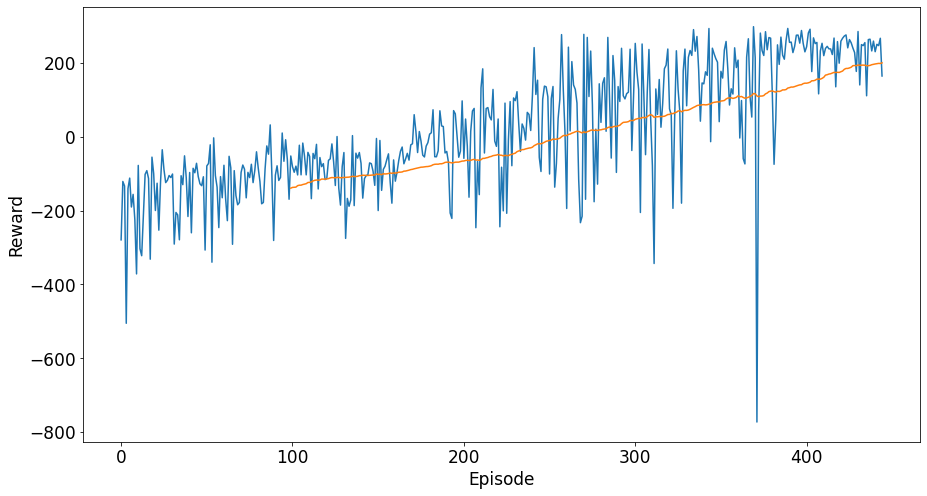

<Figure size 432x288 with 0 Axes>

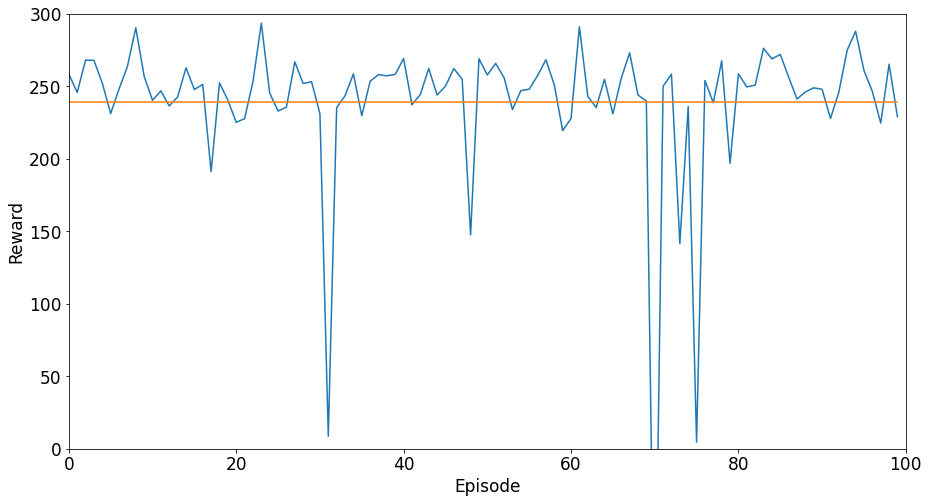

<Figure size 432x288 with 0 Axes>

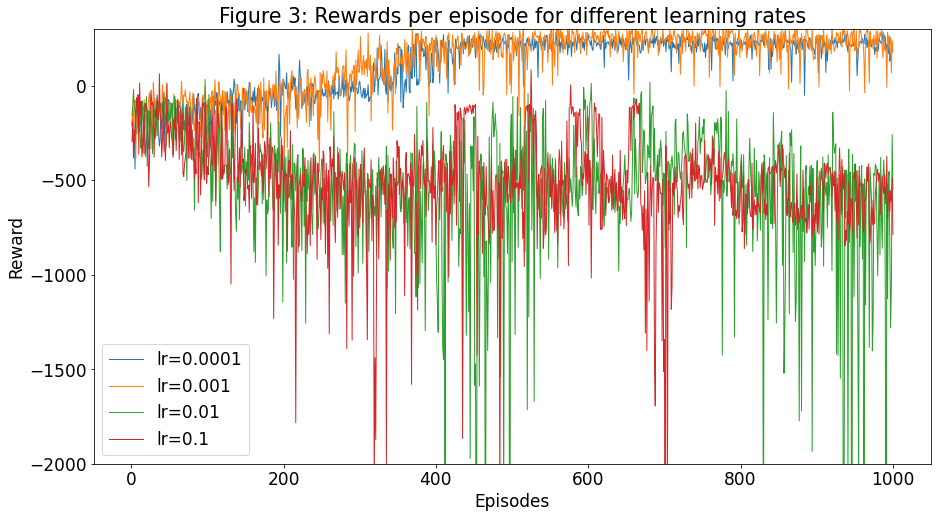

<Figure size 432x288 with 0 Axes>

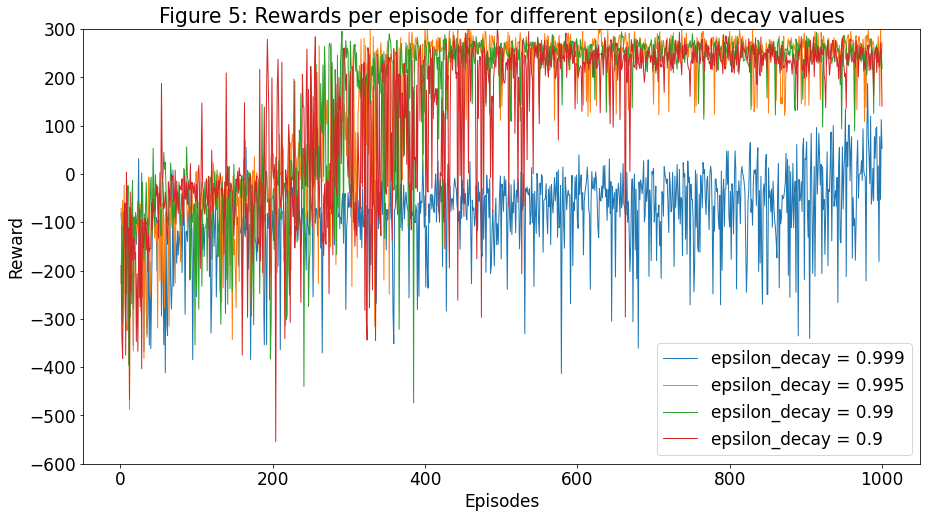

<Figure size 432x288 with 0 Axes>

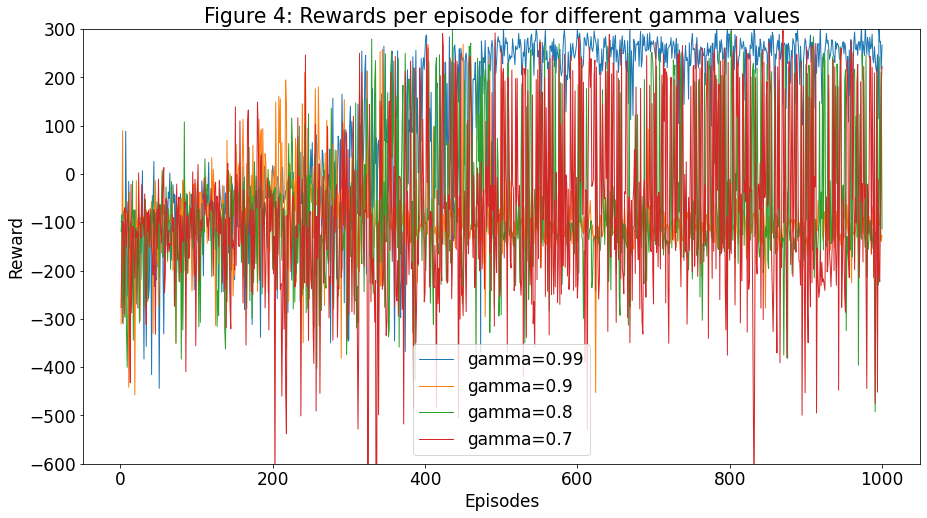

In [9]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')

    # set seeds
    env.seed(21)
    np.random.seed(21)

    # setting up params
    lr = 0.001
    epsilon = 1.0
    epsilon_decay = 0.995
    gamma = 0.99
    training_episodes = 2000
    print('St')
    model = DQN(env, lr, gamma, epsilon, epsilon_decay)
    model.train(training_episodes, True)

    # Save Everything
    save_dir = "saved_models"
    # Save trained model
    model.save(save_dir + "trained_model.h5")

    # Save Rewards list
    pickle.dump(model.rewards_list, open(save_dir + "train_rewards_list.p", "wb"))
    rewards_list = pickle.load(open(save_dir + "train_rewards_list.p", "rb"))

    # plot reward in graph
    reward_df = pd.DataFrame(rewards_list)
    plot_df(reward_df, "Figure 1: Reward for each training episode", "Reward for each training episode", "Episode","Reward")

    # Test the model
    trained_model = load_model(save_dir + "trained_model.h5")
    test_rewards = test_already_trained_model(trained_model)
    pickle.dump(test_rewards, open(save_dir + "test_rewards.p", "wb"))
    test_rewards = pickle.load(open(save_dir + "test_rewards.p", "rb"))

    plot_df2(pd.DataFrame(test_rewards), "Figure 2: Reward for each testing episode","Reward for each testing episode", "Episode", "Reward")
    print("Training and Testing Completed...!")

    # Run experiments for hyper-parameter
    run_experiment_for_lr()
    run_experiment_for_ed()
    run_experiment_for_gamma()